# Install packages and download data

In [ ]:
pip install git+https://github.com/keras-team/keras-tuner.git

In [ ]:
pip install autokeras

In [ ]:
!wget ftp://ftp.nersc.no/pub/ml_course/data4cnn.npz

## Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import view_as_windows

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import autokeras as ak

# Load data and prepare for CNN

In [3]:
# Load 2D data with 2 bands from a SAR image and sea ice concentration
img_hh = np.load('data4cnn.npz')['img_hh']
img_hv = np.load('data4cnn.npz')['img_hv']
sic = np.load('data4cnn.npz')['sic']
print(img_hh.shape, img_hv.shape, sic.shape)

(2500, 2500) (2500, 2500) (500, 500)


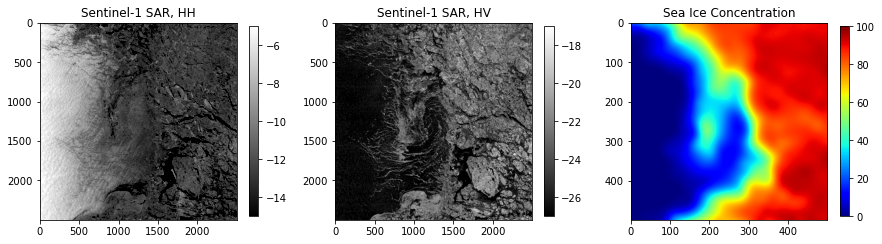

In [4]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
img0 = ax[0].imshow(img_hh.astype(float), clim=[-15, -5], cmap='gray')
img1 = ax[1].imshow(img_hv.astype(float), clim=[-27, -17], cmap='gray')
img2 = ax[2].imshow(sic, clim=[0,100], cmap='jet')

plt.colorbar(img0, ax=ax[0], shrink=0.7)
plt.colorbar(img1, ax=ax[1], shrink=0.7)
plt.colorbar(img2, ax=ax[2], shrink=0.7)

ax[0].set_title('Sentinel-1 SAR, HH')
ax[1].set_title('Sentinel-1 SAR, HV')
ax[2].set_title('Sea Ice Concentration')
plt.show()

In [5]:
# Create training input and output data

# Input: 
# Small patches from SAR images from two bands
# Shape: N x 25 x 25 x 2

# Output:
# Average concentration for a given patch
# Shape: N x 1

# Define size pf SAR image patch and step at which the patches are sampled
ws_sar = 25
stp_sar = 50
# Define size and step for SIC (input SIC image is 5 times smaller than SAR image)
ws_sic = int(ws_sar/5)
stp_sic = int(stp_sar/5)

# Create samples using view_as_windows
# Shape: number_of_windows_in_Y x number_of_windows_in_X x window_size_Y x window_size_X
hh = view_as_windows(img_hh, ws_sar, stp_sar)
hv = view_as_windows(img_hv, ws_sar, stp_sar)
ic = view_as_windows(sic, ws_sic, stp_sic)
print(hh.shape, ic.shape)

# Reshape into N x window_size_Y x window_size_X
hhr = hh.reshape(hh.shape[0]*hh.shape[1], ws_sar, ws_sar)
hvr = hv.reshape(hv.shape[0]*hv.shape[1], ws_sar, ws_sar)
icr = ic.reshape(hv.shape[0]*hv.shape[1], ws_sic, ws_sic)
print(hvr.shape, icr.shape)


(50, 50, 25, 25) (50, 50, 5, 5)
(2500, 25, 25) (2500, 5, 5)


In [6]:
# Find valid samples
# Finite values of SAR and valid values of SIC
valid = np.where(np.isfinite(hvr.min(axis=(1,2))) * (icr.min(axis=(1,2)) >= 0))[0]
print(valid.shape)

(2263,)


In [7]:
# Stack into shapes for CNN
# Input:
# N_samples x WIDTH x HEIGHT x BANDS
# Output:
# N_samples
x = np.stack([hvr, hhr], axis=3)[valid]
y = icr.mean(axis=(1,2))[valid]
print(x.shape, y.shape)

(2263, 25, 25, 2) (2263,)


# Train a simplest CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 5)         95        
_________________________________________________________________
flatten (Flatten)            (None, 2645)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2646      
Total params: 2,741
Trainable params: 2,741
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 0s 9ms/step - loss: 3734.5718 - val_loss: 2231.7224
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 1806.6639 - val_loss: 1640.3813
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 1545.2341 - val_loss: 1579.3911
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 

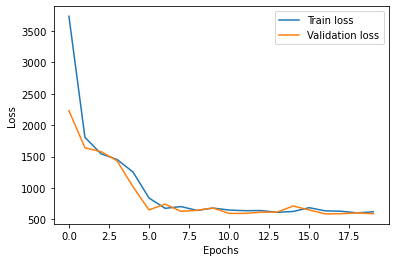

In [8]:
# Create a CNN with an simplest configuration
# Sequential type NN: one input + hidden layers + one output
m = Sequential()
# Convolutional layer. Input: SAR in HH and HV polarisations
m.add(Conv2D(
    filters=5, 
    kernel_size=(3,3), 
    strides=(1,1), 
    padding='valid', 
    activation='relu', 
    input_shape=x.shape[1:]))
# Reshape from 2D to 1D
m.add(Flatten())
# Output neuron with SIC
m.add(Dense(units=1, kernel_initializer='random_normal'))

# Plot summary
m.summary()

# Compile model and set how to compute LOSS and how to Optimize
m.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train model in 20 epochs with batch_size = 100. 20% of data go to validation
h1 = m.fit(x, y, batch_size=100, epochs=20, validation_split=0.2)

# Plot how eeror was decreasing with training
plt.plot(h1.history['loss'], label='Train loss')
plt.plot(h1.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print('LOSS', h1.history['loss'][-1], h1.history['val_loss'][-1])    


# Apply the simplest CNN to the training data

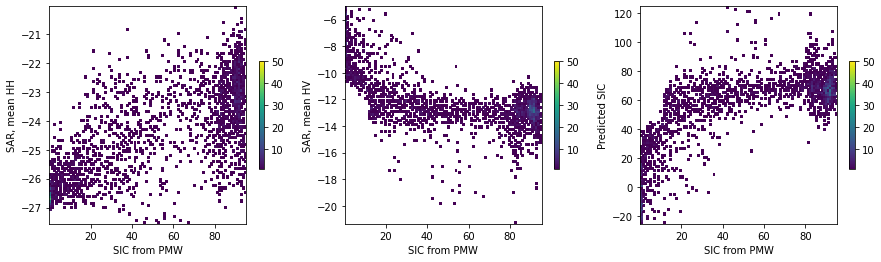

In [9]:
# predicted SIC
y_pred = m.predict(x).flatten()

# average over SAR sub-images
x_avg = x.mean(axis=(1,2))
avg_hh = x_avg[:,0]
avg_hv = x_avg[:,1]

fig, ax = plt.subplots(1, 3, figsize=(15,4))
im0 = ax[0].hist2d(y, avg_hh, 100, cmin=1, vmax=50)[3]
plt.colorbar(im0, ax=ax[0], shrink=0.5)
ax[0].set_ylabel('SAR, mean HH')
ax[0].set_xlabel('SIC from PMW')

im1 = ax[1].hist2d(y, avg_hv, 100, cmin=1, vmax=50)[3]
plt.colorbar(im1, ax=ax[1], shrink=0.5)
ax[1].set_ylabel('SAR, mean HV')
ax[1].set_xlabel('SIC from PMW')

im2 = ax[2].hist2d(y, y_pred, 100, cmin=1, vmax=50)[3]
plt.colorbar(im2, ax=ax[2], shrink=0.5)
ax[2].set_ylabel('Predicted SIC')
ax[2].set_xlabel('SIC from PMW')
plt.show()

# Apply the simplest CNN to all data and plot maps

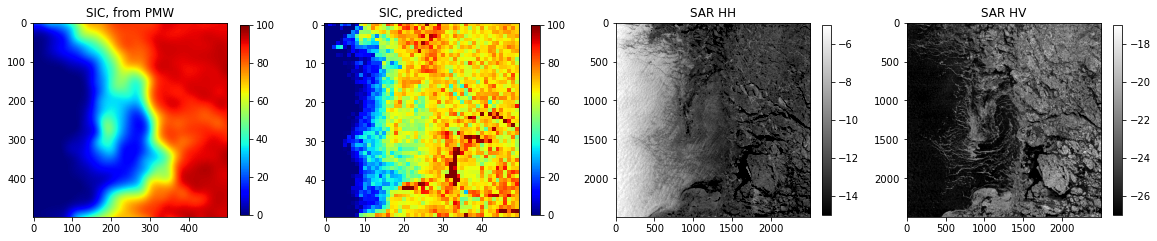

In [10]:
x_all = np.stack([hvr, hhr], axis=3)
y_all = m.predict(x_all)
y_all.shape = hv.shape[:2]

fig, ax = plt.subplots(1,4, figsize=(20,5))
img0 = ax[0].imshow(sic, clim=[0,100], cmap='jet')
ax[0].set_title('SIC, from PMW')
img1 = ax[1].imshow(y_all, clim=[0,100], cmap='jet')
ax[1].set_title('SIC, predicted')
img2 = ax[2].imshow(img_hh.astype(float), clim=[-15, -5], cmap='gray')
ax[2].set_title('SAR HH')
img3 = ax[3].imshow(img_hv.astype(float), clim=[-27, -17], cmap='gray')
ax[3].set_title('SAR HV')

for img, a in zip([img0, img1, img2, img3], ax):
  plt.colorbar(img, ax=a, shrink=0.7)

plt.show()

# Let's make more complicated architectures and test

In [38]:
# Several models are defined in dictionary mm
mm = {}

mm['cd'] = Sequential()
mm['cd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['cd'].add(Flatten())
mm['cd'].add(Dense(1, kernel_initializer='random_normal'))

mm['cpd'] = Sequential()
mm['cpd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['cpd'].add(MaxPooling2D(2, 2))
mm['cpd'].add(Flatten())
mm['cpd'].add(Dense(1, kernel_initializer='random_normal'))

mm['cpdd'] = Sequential()
mm['cpdd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['cpdd'].add(MaxPooling2D(2, 2))
mm['cpdd'].add(Flatten())
mm['cpdd'].add(Dense(10))
mm['cpdd'].add(Dense(1, kernel_initializer='random_normal'))

mm['ccpdd'] = Sequential()
mm['ccpdd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['ccpdd'].add(Conv2D(5, 3, activation='relu'))
mm['ccpdd'].add(MaxPooling2D(2, 2))
mm['ccpdd'].add(Flatten())
mm['ccpdd'].add(Dense(10))
mm['ccpdd'].add(Dense(1, kernel_initializer='random_normal'))

mm['ccpccpdd'] = Sequential()
mm['ccpccpdd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['ccpccpdd'].add(Conv2D(5, 3, activation='relu'))
mm['ccpccpdd'].add(MaxPooling2D(2, 2))
mm['ccpccpdd'].add(Conv2D(10, 3, activation='relu'))
mm['ccpccpdd'].add(Conv2D(10, 3, activation='relu'))
mm['ccpccpdd'].add(MaxPooling2D(2, 2))
mm['ccpccpdd'].add(Flatten())
mm['ccpccpdd'].add(Dense(10))
mm['ccpccpdd'].add(Dense(1, kernel_initializer='random_normal'))

def compile_fit(m, epochs=15):
    """ Compile and train the model. Print accuracy and summary. 
    Inputs
    ------
    m : Sequential model
    epochs: int

    Returns
    -------
    h : history of training
    """
    m.compile(loss='mean_squared_error', optimizer=Adam())
    h = m.fit(x, y, batch_size=100, epochs=epochs, validation_split=0.2, verbose=False)
    print(h.history['loss'][-1], h.history['val_loss'][-1])    
    m.summary()
    print('\n\n')
    return h


# Train all the models


In [39]:
# Keep histories in dictionary hh 
hh = {name: compile_fit(mm[name]) for name in mm}

505.6448059082031 544.851318359375
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 23, 23, 5)         95        
_________________________________________________________________
flatten_32 (Flatten)         (None, 2645)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 2646      
Total params: 2,741
Trainable params: 2,741
Non-trainable params: 0
_________________________________________________________________



457.3892517089844 461.710693359375
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 23, 23, 5)         95        
_________________________________________________________________
max_pooling2d_32 (Max

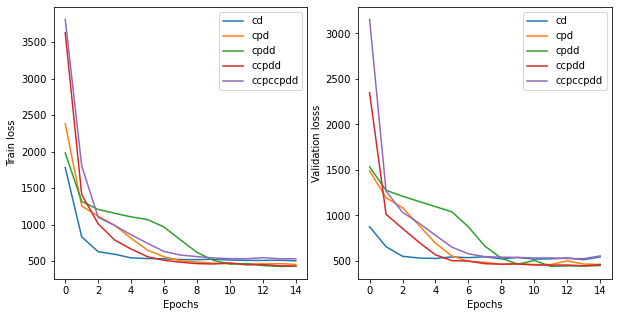

In [40]:
# Plot histories for different models
fig, ax = plt.subplots(1,2,figsize=(10,5))
for name in hh:
    ax[0].plot(hh[name].history['loss'], label=name)
    ax[1].plot(hh[name].history['val_loss'], label=name)
    
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Train loss')
ax[1].set_ylabel('Validation losss')

plt.show()

# Regularization

In [47]:
# Train for many epochs and check history
# The history shows that the model was overfitted
# At some point val_loss stoped decreasing (and started increasing, not always)
epochs = 300
h1 = compile_fit(mm['cpdd'], epochs=epochs)

208.06544494628906 318.962646484375
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 23, 23, 5)         95        
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 11, 11, 5)         0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 605)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 10)                6060      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 11        
Total params: 6,166
Trainable params: 6,166
Non-trainable params: 0
_________________________________________________________________





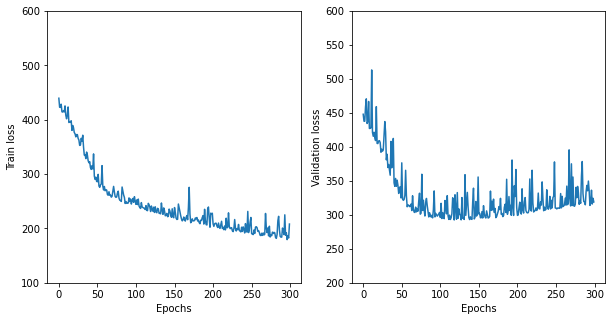

In [48]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(h1.history['loss'], label='ccpccpdd')
ax[1].plot(h1.history['val_loss'])
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Train loss')
ax[1].set_ylabel('Validation losss')
ax[0].set_ylim([100, 600])
ax[1].set_ylim([200, 600])
plt.show()

In [49]:
mm['cpddr'] = Sequential()

# Normalize input data batch-by-batch
mm['cpddr'].add(BatchNormalization(input_shape=x.shape[1:]))
mm['cpddr'].add(Conv2D(5, 3, activation='relu'))
mm['cpddr'].add(MaxPooling2D(2, 2))
mm['cpddr'].add(Flatten())

# Randomly remove 10% neurons on every epoch
mm['cpddr'].add(Dropout(0.1))

# Apply L2-regularization
mm['cpddr'].add(Dense(10, kernel_regularizer=l2(0.01)))
mm['cpddr'].add(Dense(1, kernel_initializer='random_normal'))

h2 = compile_fit(mm['cpddr'], epochs=epochs)

208.31044006347656 286.9782409667969
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 25, 25, 2)         8         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 23, 23, 5)         95        
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 11, 11, 5)         0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 605)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 605)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 10)                6060      
_________________________________________________________________
dense_62 (Dense)

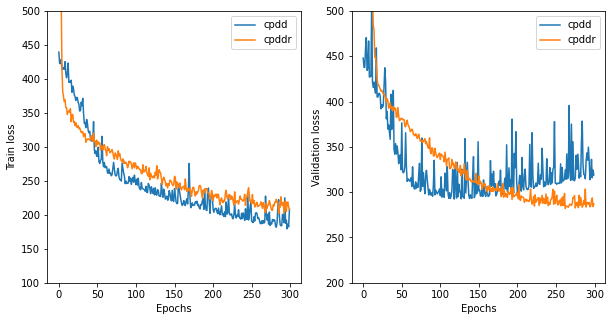

In [51]:
# Plot histories of the original and regularized models
# The regularized model has higher loss but has not been overfitted
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(h1.history['loss'], label='cpdd')
ax[0].plot(h2.history['loss'], label='cpddr')
ax[1].plot(h1.history['val_loss'], label='cpdd')
ax[1].plot(h2.history['val_loss'], label='cpddr')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim([100, 500])
ax[1].set_ylim([200, 500])

ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Train loss')
ax[1].set_ylabel('Validation losss')

plt.show()

# Automatic selection of configuration

In [52]:
# ================================
# How functional API works:
# input = Input(input_shape=10)
# x = Dense(10)(input)
# x = Dense(20)(x)
# x = Dense(30)(x)
# model = Model(input, x)
# ================================

# Define a GENERIC structure of an image regressor using functional API
input_node = ak.ImageInput()
out_node = ak.Normalization()(input_node)
out_node = ak.ConvBlock()(out_node)
out_node = ak.DenseBlock()(out_node)
output_node = ak.RegressionHead()(out_node)

# Also specify how many trials shoul be run for finding a best arcitecture
reg = ak.AutoModel(
    inputs=input_node,
    outputs=output_node, 
    overwrite=True, 
    max_trials=5,
    project_name='reg',
    directory='ak_model',
)

In [53]:
# Run fitting of parameters and hyper-parameters
reg.fit(x, y, validation_split=0.2, epochs=10, batch_size=100)

Trial 5 Complete [00h 00m 48s]
val_loss: 493.7005920410156

Best val_loss So Far: 411.52789306640625
Total elapsed time: 00h 02m 01s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
23/23 [==============================] - 3s 106ms/step - loss: 2068.7981 - mean_squared_error: 2068.7981
Epoch 2/10
23/23 [==============================] - 2s 105ms/step - loss: 639.9410 - mean_squared_error: 639.9410
Epoch 3/10
23/23 [==============================] - 2s 105ms/step - loss: 568.1180 - mean_squared_error: 568.1180
Epoch 4/10
23/23 [==============================] - 2s 106ms/step - loss: 503.3223 - mean_squared_error: 503.3223
Epoch 5/10
23/23 [==============================] - 2s 105ms/step - loss: 461.1057 - mean_squared_error: 461.1057
Epoch 6/10
23/23 [==============================] - 2s 105ms/step - loss: 434.2901 - mean_squared_error: 434.2901
Epoch 7/10
23/23 [==============================] - 2s 106ms/step - loss: 411.0640 - mean_squared_error: 411.0640
Epoch 8/10
23/23 [===========

In [54]:
# Show the automatic model
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 2)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 25, 25, 2)         0         
_________________________________________________________________
normalization (Normalization (None, 25, 25, 2)         5         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 256)       4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        73760     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248  

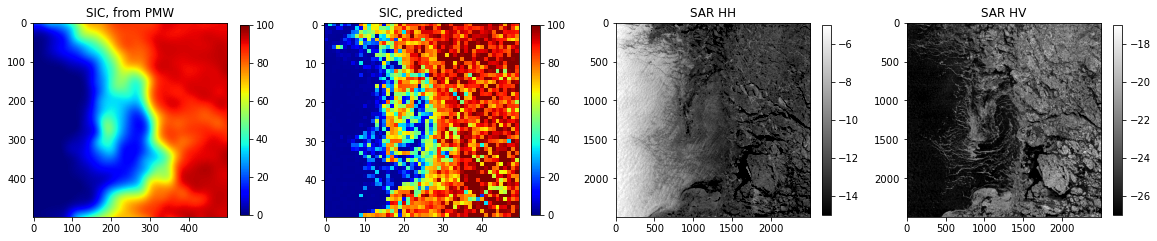

In [55]:
x_all = np.stack([hvr, hhr], axis=3)
y_all_ak = model.predict(x_all)
y_all_ak.shape = hv.shape[:2]

fig, ax = plt.subplots(1,4, figsize=(20,5))
img0 = ax[0].imshow(sic, clim=[0,100], cmap='jet')
ax[0].set_title('SIC, from PMW')
img1 = ax[1].imshow(y_all_ak, clim=[0,100], cmap='jet')
ax[1].set_title('SIC, predicted')
img2 = ax[2].imshow(img_hh.astype(float), clim=[-15, -5], cmap='gray')
ax[2].set_title('SAR HH')
img3 = ax[3].imshow(img_hv.astype(float), clim=[-27, -17], cmap='gray')
ax[3].set_title('SAR HV')

for img, a in zip([img0, img1, img2, img3], ax):
    plt.colorbar(img, ax=a, shrink=0.7)

plt.show()